# Prédire la demande en électricité

#### Il s'agit du projet numéro 9 de la formation DATA Analyste de chez OpenClassRooms, ce projet nous demande d'effectuer une prédiction d'électricité qui nous a été demandé par la société qui nous embauche, en effet, nous somme employé par l'entreprise Enercoop qui est une société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

#### La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !

In [1]:
# Importation des différentes librairies utile à notre mission
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro

import warnings                                  
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Principales versions utilisées
print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))
print("Statsmodels : " + str(sm.__version__))

Jupyter Notebook : 1.3.4
Pandas : 1.3.4
Numpy : 1.20.3
Matplotlib : 3.4.3
Seaborn : 0.11.2
Statsmodels : 0.12.2


In [3]:
# Affichage de toutes les colonnes dans notre dataframe
#pd.set_option("display.max_columns", 100)

#Paramètres de style
pylab.style.use('ggplot') 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (18, 8),
          'lines.linewidth': 1.5,
          'axes.labelsize': 'x-large',
          'axes.titlesize':20,
          'axes.titleweight':'bold',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
consommation = pd.read_csv('consommation.csv', sep = ';')
display(consommation.head(5))
display(consommation.tail(5))

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
0,0000-00,Données consolidées,Grand-Est,11346,8643.0,1120,22.0,2,1095,565,...,4545,6711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données consolidées,Nouvelle-Aquitaine,5289,4179.0,164,NaN,0,164,419,...,4578,711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données consolidées,Auvergne-Rhône-Alpes,11622,8382.0,334,6.0,11,316,2630,...,6834,4483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données consolidées,Bourgogne-Franche-Comté,467,NaN,124,NaN,0,123,89,...,2188,-1724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données consolidées,Bretagne,535,NaN,182,NaN,4,178,59,...,2443,-1915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
1138,2020-02,Données consolidées,Occitanie,3243,1583.0,63,NaN,0,63,1004,...,3336,-269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,2020-02,Données consolidées,Normandie,4739,4074.0,284,-5.0,29,260,8,...,2619,2120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,2020-02,Données consolidées,Hauts-de-France,5572,2852.0,815,0.0,5,809,1,...,4578,994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1141,2020-02,Données consolidées,PACA,2039,NaN,591,0.0,14,577,1266,...,3598,-1565.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1142,2020-02,Données consolidées,Pays-de-la-Loire,739,NaN,338,66.0,13,257,2,...,2532,-1792.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Visualisation rapide de notre dataset
consommation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      1143 non-null   object 
 1   Qualité                                   1143 non-null   object 
 2   Territoire                                1143 non-null   object 
 3   Production totale                         1143 non-null   int64  
 4   Production nucléaire                      708 non-null    float64
 5   Production thermique totale               1143 non-null   int64  
 6   Production thermique charbon              769 non-null    float64
 7   Production thermique fioul                1143 non-null   int64  
 8   Production thermique gaz                  1143 non-null   int64  
 9   Production hydraulique                    1143 non-null   int64  
 10  Production éolien                   

In [6]:
# Vérification des valeurs manquantes présent dans notre dataframe
consommation.isna().sum()

Mois                                           0
Qualité                                        0
Territoire                                     0
Production totale                              0
Production nucléaire                         435
Production thermique totale                    0
Production thermique charbon                 374
Production thermique fioul                     0
Production thermique gaz                       0
Production hydraulique                         0
Production éolien                              0
Production solaire                             0
Production bioénergies                         0
Consommation totale                            0
Solde exportateur                             84
Echanges export                             1044
Echanges import                             1044
Echanges avec le Royaume-Uni                1044
Echanges avec l'Espagne                     1044
Echanges avec l'Italie                      1044
Echanges avec la Sui

Les valeurs manquantes peut-être traduit par un manque de production de certaines régions(ex : la bretagne ne produit pas d'énergie nucléaire et donc la valeur 'NaN' est attribué.)

In [7]:
# Création d'un dataset qui va répertorié toute la consommation totale de la France par année
conso_annee = consommation.copy()
conso_annee = conso_annee[['Mois', 'Territoire', 'Consommation totale']]
conso_annee = conso_annee[conso_annee.Territoire == 'France']
conso_annee.drop('Territoire', axis = 1, inplace = True)
conso_annee.head(5)

,Mois,Consommation totale
6,0000-00,49559
13,2012-01,51086
14,2012-02,54476
15,2012-03,43156
16,2012-04,40176


In [8]:
# Suppréssion de l'individus n°1 car aucune valeur temporelle n'est renseigné
conso_annee.drop(6, axis = 0, inplace = True)

# Vérification rapide de nos données
display(conso_annee.head(5))
display(conso_annee.tail(5))
print(conso_annee.shape)

,Mois,Consommation totale
13,2012-01,51086
14,2012-02,54476
15,2012-03,43156
16,2012-04,40176
17,2012-05,35257


,Mois,Consommation totale
1084,2019-10,36482
1097,2019-11,44180
1110,2019-12,47096
1123,2020-01,43304
1136,2020-02,43169


(98, 2)


In [9]:
# Conversion de notre variable 'Mois' en variable de type 'datetime' pour pouvoir réaliser un graphique
conso_annee['Mois'] = pd.to_datetime(conso_annee['Mois'])

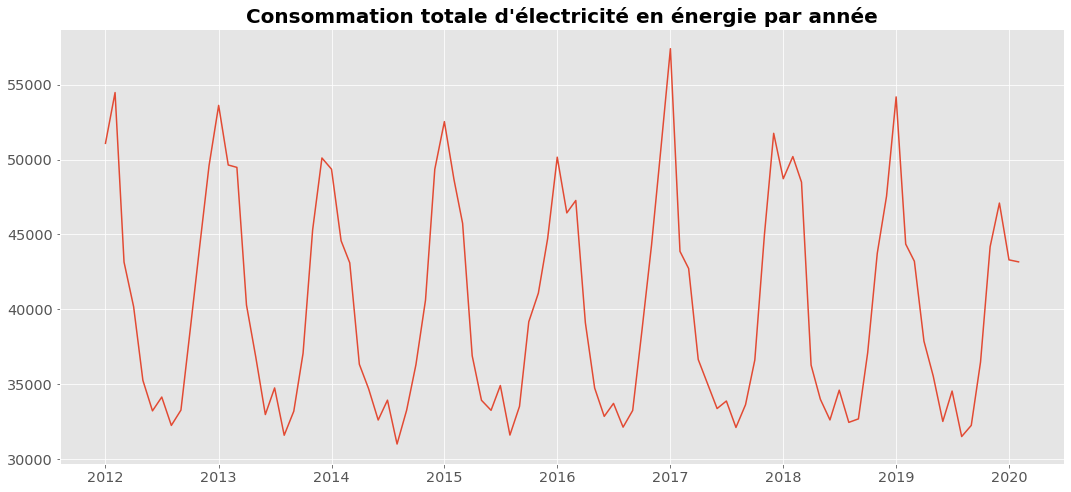

In [10]:
# Réalisation d'un graphique de la variable 'consommation totale'
plt.plot(conso_annee['Mois'], conso_annee['Consommation totale'])
plt.title("Consommation totale d'électricité en énergie par année")
plt.savefig("Graphs/Consommation totale d'électricité en énergie par année.png")
plt.show()

Il est clair qu'un cycle s'opère sur nos données assez régulièrement et de même amplitude au fil du temps, nous allons corrigé nos données mensuelle de l'effet température et qui sera effectuer via une régression linéaire. 

### Mission 1 : Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

In [11]:
# Récapitulatif de la consommation électrique annuelle
# Changement d'index par la variable 'Mois' pour pouvoir effectuer un 'resample' pour additionner chaque consommation électrique par mois
conso_annee.set_index('Mois', inplace = True)
conso_annee.resample('Y').sum()

,Consommation totale
Mois,
2012-12-31,489517
2013-12-31,494842
2014-12-31,465150
2015-12-31,476050
2016-12-31,483219
2017-12-31,482008
2018-12-31,478431
2019-12-31,473739
2020-12-31,86473


On peut déjà déduire que le consommation électrique par année et plutôt homogène avec néanmoins un pique pour l'année 2013(494842 GWh) pour le plus haut et 2014(465150 GWh) pour le pique le plus bas. Voyons quelle part à le chauffage électrique dans la consommation totale. 

In [12]:
# Importation du dataset 'dju' qui est un traitement de jeu de données exporté du site Cegibat, 
# l'expertise efficacité énergétique de GRDF pour corriger les données de l'effet température
data_dju = pd.read_csv('dju-Copy1.csv')
data_dju

,annee,1,2,3,4,5,6,7,8,9,10,11,12,total
11,2021,396.7,302.8,271.0,228.3,138.3,1.4,0.0,0.0,0.0,0.0,0.0,0.0,1338.2
12,2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8,1785.9
13,2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3,1989.0
14,2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9,2002.2
15,2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0,2040.6
16,2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3
17,2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
18,2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
19,2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
20,2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5


l'année 2021 ne peut pas être pris en compte car nous n'avons pas de données pendant 6 mois de l'année.

In [13]:
# Suppression de l'année 2021 et de la variable 'total' de notre dataset
data_dju.drop([11], axis = 0, inplace = True)
data_dju.drop('total', axis = 1, inplace = True)

In [14]:
# Nous allons mettre la variable 'annee' comme index de notre dataset
data_dju.set_index('annee', inplace = True)
data_dju.head()

,1,2,3,4,5,6,7,8,9,10,11,12
annee,,,,,,,,,,,,
2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8
2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3
2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9
2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0
2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8


In [15]:
# Création d'un nouveau dataframe 'vierge'
dju = {'Mois' : [], 'dju_chauffage' : []}

for year in data_dju.index.values:
    for month in data_dju.columns:
        dju['Mois'].append(f"{year}-{month}") # Ajout des année et des mois dans la même variable 'mois'
        dju['dju_chauffage'].append(data_dju.loc[year, month]) # Ajout des valeurs contenu dans 'data_dju' dans l'ordre [year, month]
        
dju = pd.DataFrame(dju)
dju['Mois'] = pd.to_datetime(dju['Mois']) # Conversion de la variable 'mois' en datetime64
dju.head()

,Mois,dju_chauffage
0,2020-01-01,339.0
1,2020-02-01,249.6
2,2020-03-01,268.6
3,2020-04-01,81.4
4,2020-05-01,65.7


In [16]:
# Changement d'index par la variable 'mois'
dju.set_index('Mois', inplace = True)

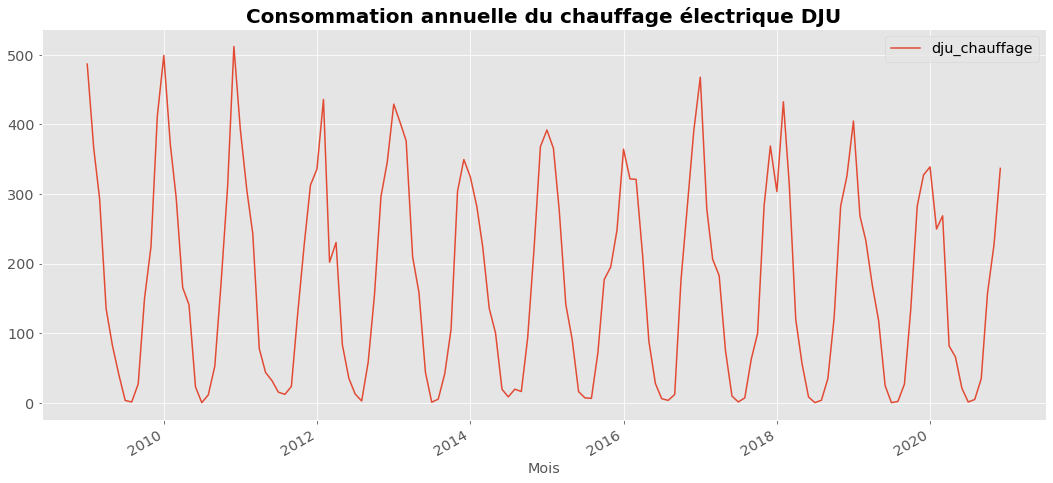

In [17]:
# Création d'un graphique pour visualisation la distribution de la variable 'dju_chauffage'
dju.plot()
plt.title('Consommation annuelle du chauffage électrique DJU')
plt.savefig("Graphs/Consommation annuelle du chauffage électrique DJU.png")
plt.show()

Une saisonnalité est clairement observable dans notre variable 'dju_chauffage'. Les dju (Degré Jour Unifié) nous permettra de calculé les besoins en chauffage d'un batiment.

In [18]:
# Jointure de nos deux différents dataframe 'conso_annee' & 'dju' pour avoir chaque individus l'un en face de l'autre
conso_dju = pd.merge(conso_annee, dju, how = 'inner', on = 'Mois')
display(conso_dju.head())
print(conso_dju.shape)

,Consommation totale,dju_chauffage
Mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3


(98, 2)


### Chap.1 - Corréction des données de consommation mensuelles de l'effet température

Cette correction sera réalisé par régression linéaire via la librairie Scikit-Learn.

In [19]:
from sklearn.linear_model import LinearRegression

# Stockage des valeurs dans des variables
X = conso_dju.drop(['Consommation totale'], axis = 1)
y = conso_dju['Consommation totale']

In [20]:
# Instanciation de notre modèle de régression qui va entrainer nos données
model = LinearRegression()
model.fit(X, y)

# Coefficient de détermination ou R²
print(model.score(X, y))

# Coefficient de régression linéaire
print(model.coef_[0])

0.9488809591916477
48.24262995667851


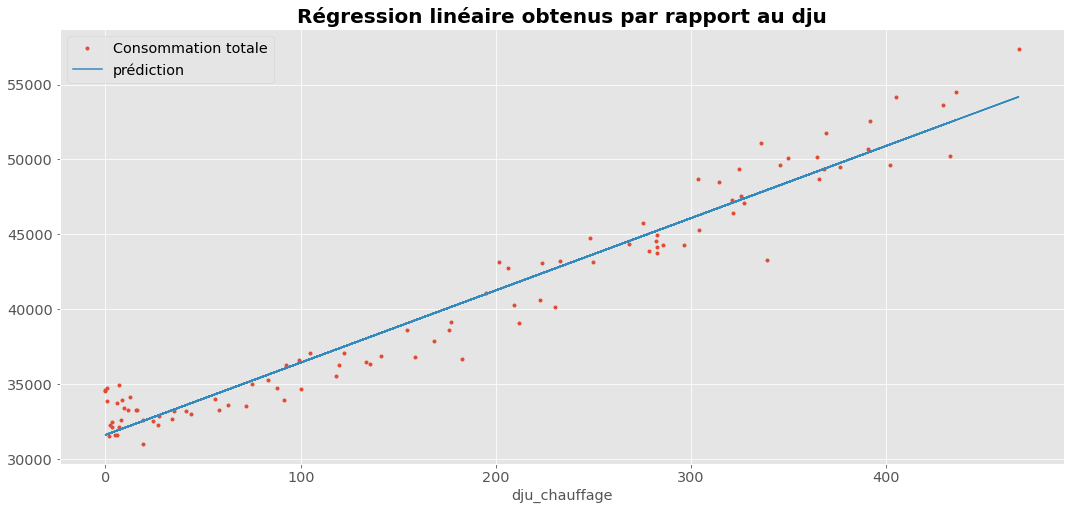

In [21]:
#Représentation de la Régression linéaire obtenue
conso_dju.plot(x = 'dju_chauffage', y = 'Consommation totale', style = '.')
plt.plot(conso_dju['dju_chauffage'], model.predict(X), label = 'prédiction')

plt.title('Régression linéaire obtenus par rapport au dju')
plt.legend()
plt.savefig("Graphs/regression_lineaire_conso_dju.png")
plt.show()

#### Le modèle de Régression linéaire peut également être traité par Statsmodels, c'est ce que nous allons voir:

In [22]:
# Préparation des données pour établir la Régression linéaire
y = conso_dju['Consommation totale']
x = sm.add_constant(conso_dju['dju_chauffage'])

In [23]:
# Nouvelle Régression linéaire par Statsmodels
# Instanciation du modèle et entrainement
reg = sm.OLS(y, x).fit()
print(reg.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation totale   R-squared:                       0.949
Model:                             OLS   Adj. R-squared:                  0.948
Method:                  Least Squares   F-statistic:                     1782.
Date:                 Wed, 18 May 2022   Prob (F-statistic):           8.57e-64
Time:                         11:25:35   Log-Likelihood:                -860.99
No. Observations:                   98   AIC:                             1726.
Df Residuals:                       96   BIC:                             1731.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.161e+04    257.913 

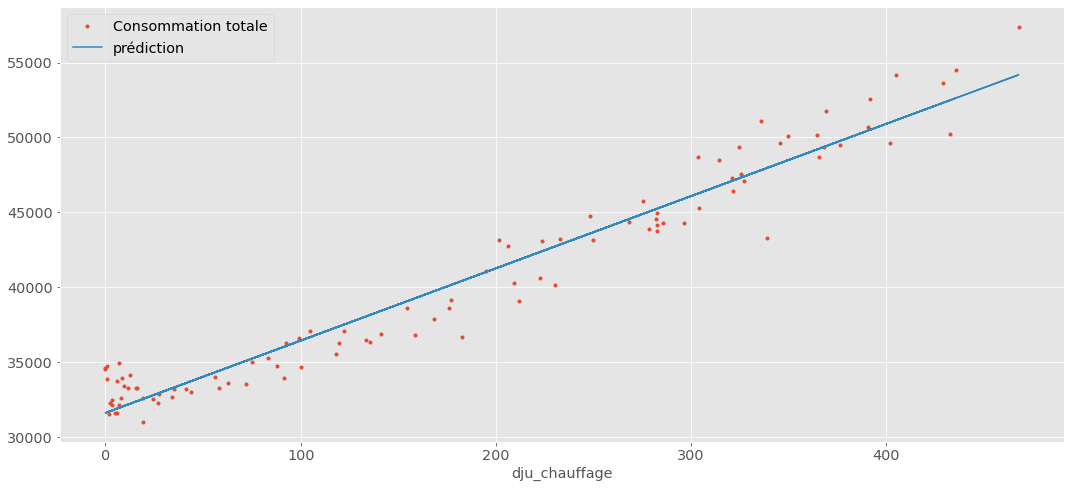

In [24]:
#Représentation de la Régression linéaire obtenue
conso_dju.plot(x = 'dju_chauffage', y = 'Consommation totale', style = '.')
plt.plot(conso_dju['dju_chauffage'], reg.predict(sm.add_constant(conso_dju['dju_chauffage'])), label = 'prédiction')

plt.legend()
plt.show()

In [25]:
#Coefficient de régression linéaire
reg.params['dju_chauffage']

48.2426299566785

Le coefficient de régression linéaire est vérifié par les deux méthodes.

In [26]:
# Corréction des données de consommation mensuelles de l'effet température (dues au chauffage électrique)
conso_dju['corr_conso'] = conso_dju['Consommation totale'] - (conso_dju['dju_chauffage'] * model.coef_[0]).astype(int)

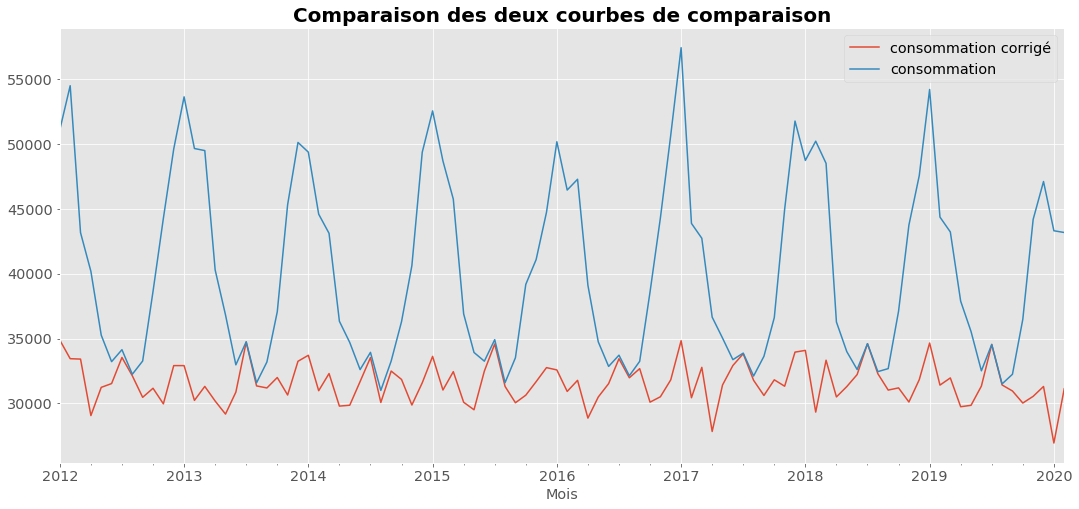

In [27]:
# Création d'un graphique qui va nous permettre de visualiser notre courbe de comparaison corrigé par une régression linéaire
conso_dju['corr_conso'].plot(label = 'consommation corrigé')
conso_dju['Consommation totale'].plot(label = 'consommation')

plt.title('Comparaison des deux courbes de comparaison')
plt.legend()
plt.savefig('Graphs/Comparaison des deux courbes de comparaison.png')
plt.show()

#### Analyse de la normalité de nos résidus(QQ-Plot, Pearson) Pour pouvoir validé notre régression linéaire

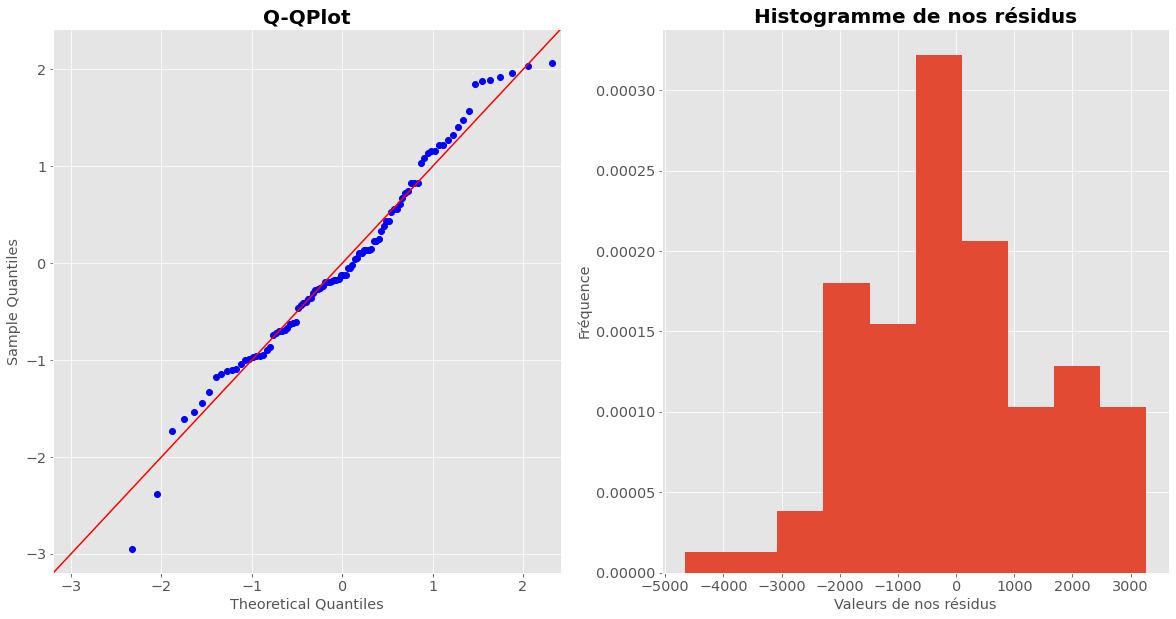

In [28]:
# Création de deux graphique qui vont nous renseigner sur la distribution de nos résidus et si ils suivent une loi normale
# grâce à un graphique de type QQplot
fig, ax = plt.subplots(1, 2, figsize = (20, 10))


# Stockage des résidus dans une variable
res = reg.resid # residuals

plt.hist(res, density = True)

# Réalisation de notre Diagrammes de probabilité à partir de nos résidus
pplot = sm.ProbPlot(res, fit = True)
fig = pplot.qqplot(line = "45", ax = ax[0])

ax[0].set_title('Q-QPlot')
ax[1].set_title('Histogramme de nos résidus')
ax[1].set_xlabel('Valeurs de nos résidus')
ax[1].set_ylabel('Fréquence')

plt.savefig('Graphs/qqplot_histo_residus_reg.png')
plt.show()

On peut identifier une distribution des résidus satisfaisante, alignée avec la distribution théorique d'une loi normale.

#### Effectuons dorénavant un test de Shapiro-Wilk(<3000 individus) pour vérifier si nos résidus suivent une loi normale, comme notre diagrammes de probabilité laisse à penser

In [29]:
# Test de Shapiro-Wilk
shapiro(reg.resid)

ShapiroResult(statistic=0.981886625289917, pvalue=0.19641254842281342)

La p-value de 0.19 ne permet pas de rejeter l'hypothèse nulle H0 de normalité des résidus avec un seuil alpha de 0.05%, le test est donc validé.

### Chap.2 - Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

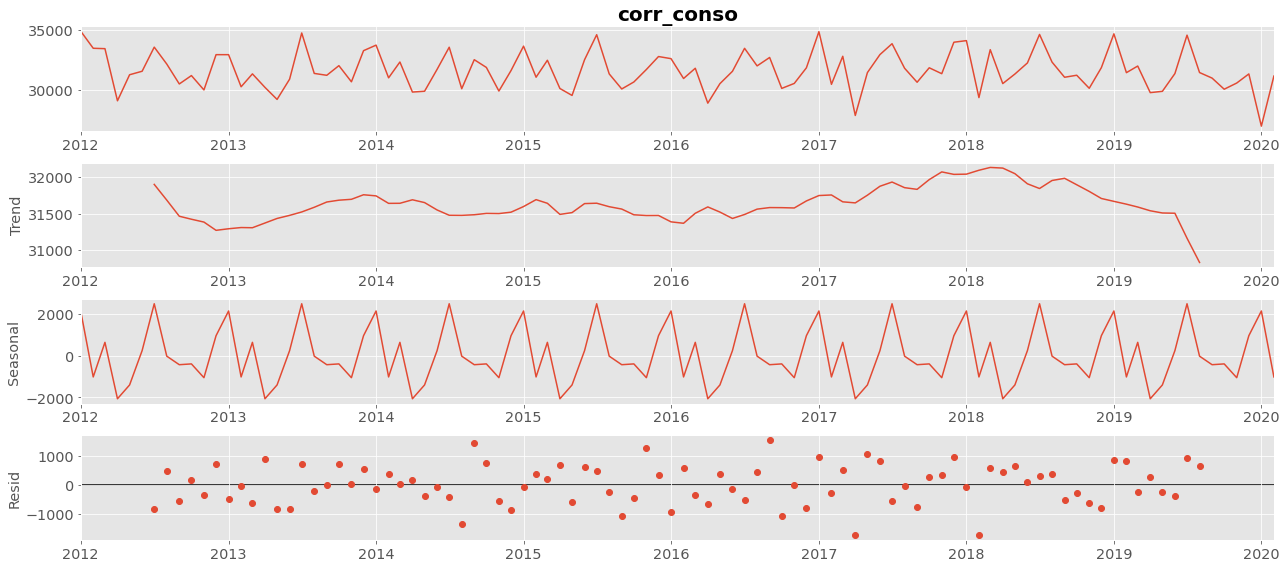

In [30]:
# Importation de la fonction 'seasonal_decompose' de statsmodels qui va nous permettre de visualiser la tendance,
# la saisonnalité et les résidus
from statsmodels.tsa.seasonal import seasonal_decompose

conso_dju_decomp = seasonal_decompose(conso_dju['corr_conso'],  model = 'additive')
conso_dju_decomp.plot()

plt.savefig('Graphs/seasonal_decompose.png')
plt.show()

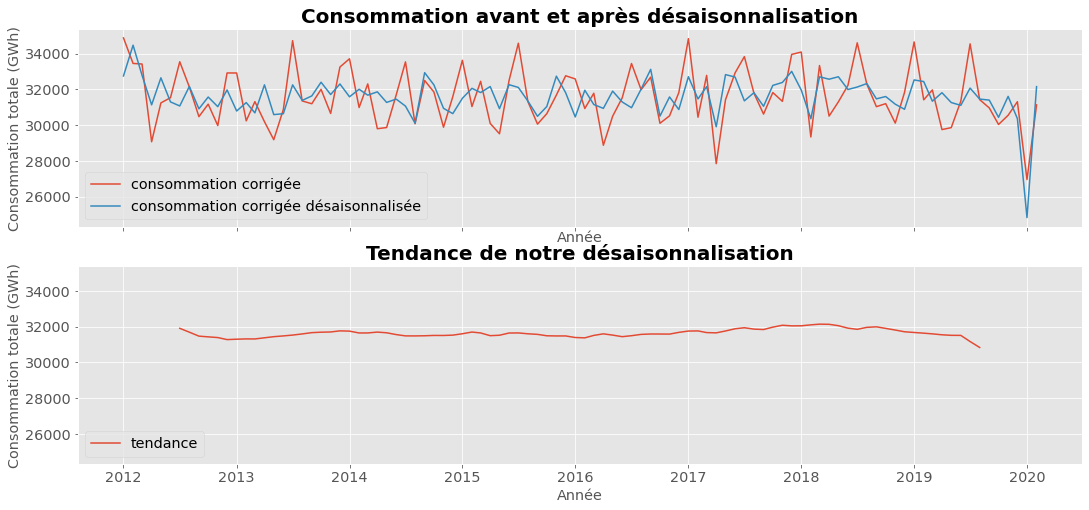

In [31]:
# Stockage du calcul de la desaisonnalité dans une variable 
conso_dju['conso_csv'] = conso_dju['corr_conso'] - conso_dju_decomp.seasonal

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Réalisation d'un graphique pour comparer nos deux variables
axs[0].plot(conso_dju['corr_conso'], label = 'consommation corrigée')
axs[0].plot(conso_dju['conso_csv'], label = 'consommation corrigée désaisonnalisée')
axs[0].set_title('Consommation avant et après désaisonnalisation')
axs[0].set_xlabel('Année')
axs[0].set_ylabel('Consommation totale (GWh)')
axs[0].legend()

axs[1].plot(conso_dju_decomp.trend, label = 'tendance')
axs[1].set_title('Tendance de notre désaisonnalisation')
axs[1].set_xlabel('Année')
axs[1].set_ylabel('Consommation totale (GWh)')
axs[1].legend(loc = 'lower left')

plt.savefig('Graphs/Consommation avant et après désaisonnalisation.png')
plt.show()

Effectivement nous avons réussi à 'lissé' un peu plus notre distribution de consommation corrigé, néanmoins la courbe n'est pas parfaitement droite.

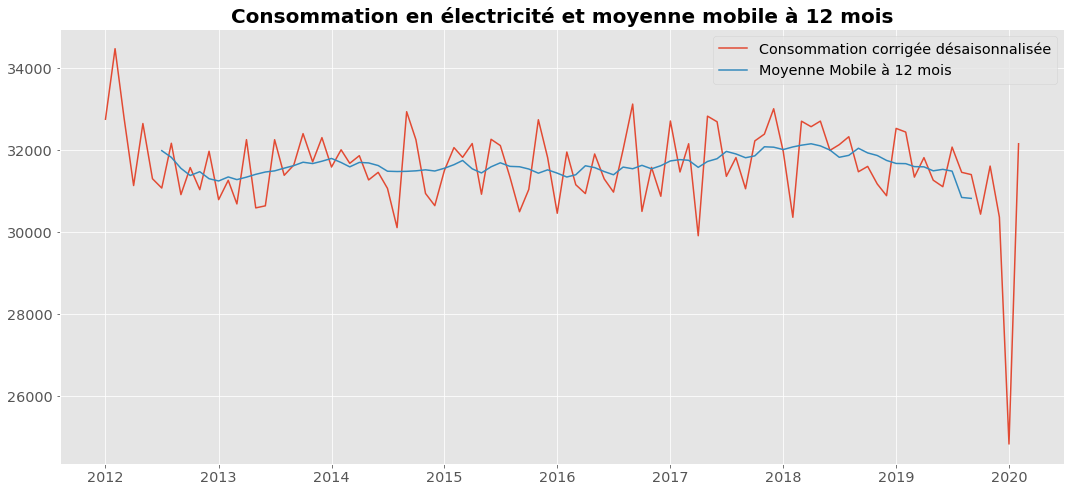

In [32]:
#Visualisation de la consommation en électricité avec moyenne mobile à 12 mois
plt.plot(conso_dju['conso_csv'], label='Consommation corrigée désaisonnalisée')

# La fonction 'rolling' va me permettre de calculer une moyenne tous les 12 individus de ma variable 'conso_csv'
plt.plot(conso_dju['conso_csv'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.legend()
plt.savefig("Graphs/conso_moyenne_mobile.png")
plt.show()

Voici à quoi ressemble la courbe des moyennes mobiles de notre courbe de consommation corrigée désaisonnalisée.

###  Chap.3 - Effectuez une prévision de la consommation sur un an, en utilisant la méthode de Holt Winters puis la méthode SARIMA sur la série temporelle.

#### La méthode Holt-Winters

In [33]:
# Stockage de la variable 'corr_conso' pour pouvoir selectionner plus facilement les individus
conso_corr = conso_dju['corr_conso']

y = conso_corr[:-12] # Sélection de tous les individus sauf les 12 derniers
y_reel12 = conso_corr[-12:] # Uniquement les 12 derniers individus

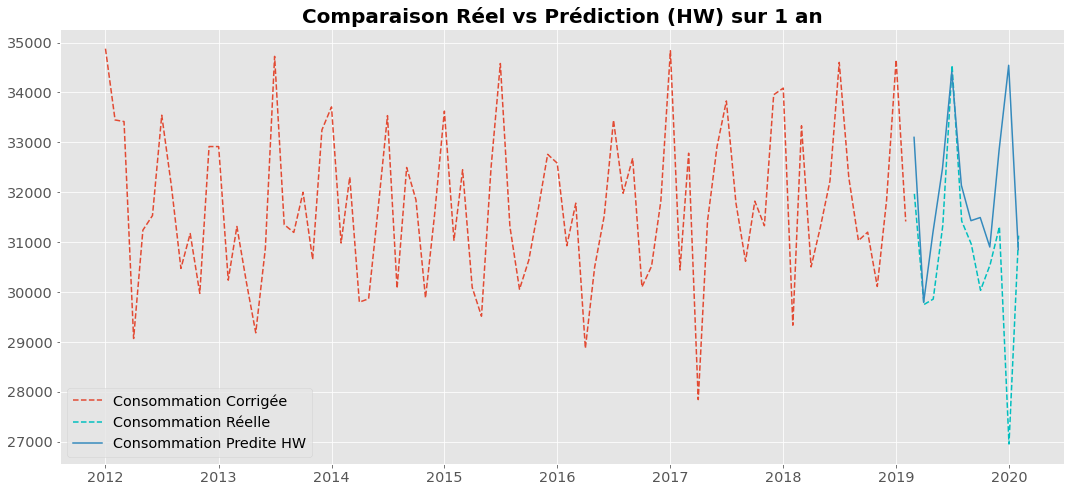

In [34]:
# Importation de la librairie qui va nous permettre d'effectuer la méthode de Holt-Winters
from statsmodels.tsa.api import ExponentialSmoothing

# Calcule de la prédiction selon la méthode Holt-Winters
hw = ExponentialSmoothing(np.asarray(y), seasonal_periods = 12, trend = 'add', seasonal = 'add').fit()
hw_pred = hw.forecast(12)

# Création d'un graphique pour comparer notre calcul de Holt-Winters
plt.figure(figsize = (18,8))
plt.plot(y[-86:], label = 'Consommation Corrigée', linestyle = 'dashed')
plt.plot(y_reel12, label = 'Consommation Réelle', linestyle = "dashed", color = 'c')
plt.plot(pd.date_range(y.index[len(y)-1], periods = 12, freq = 'M'), hw_pred, label = 'Consommation Predite HW')

plt.legend()
plt.title('Comparaison Réel vs Prédiction (HW) sur 1 an')
plt.savefig('Graphs/Comparaison Réel vs Prédiction (HW)')
plt.show()

Notre prédiction est plutôt correct néanmoins le début de l'année 2020 n'a pas été très bien prédite. Essayons sur les 2 dernières année.

In [35]:
# Stockage de la variable 'corr_conso' pour pouvoir selectionner plus facilement les individus
conso_corr = conso_dju['corr_conso']

y = conso_corr[:-24] # Sélection de tous les individus sauf les 24 derniers
y_reel24 = conso_corr[-24:] # Uniquement les 24 derniers individus

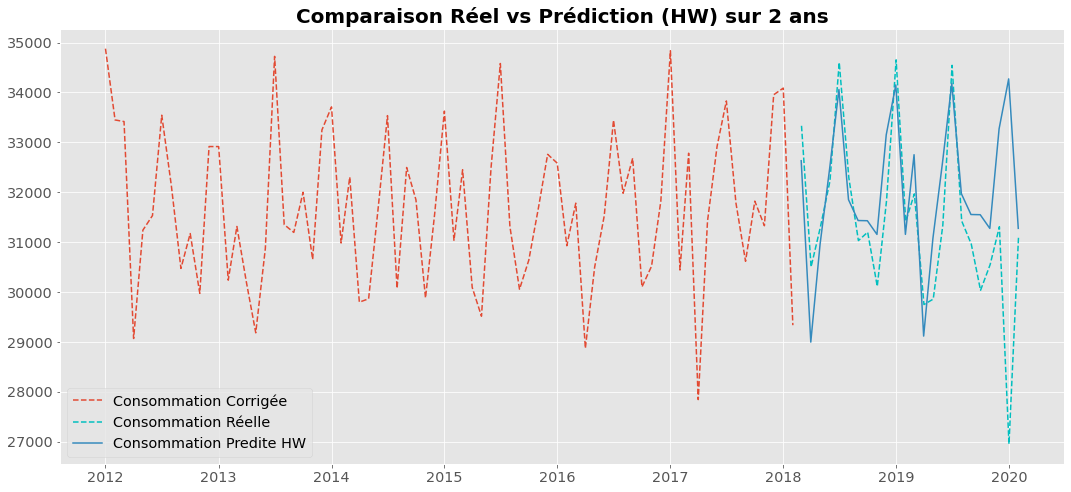

In [36]:
# Calcule de la prédiction selon la méthode Holt-Winters
hw = ExponentialSmoothing(np.asarray(y), seasonal_periods = 12, trend = 'add', seasonal = 'add').fit()
hw_pred = hw.forecast(24)

# Création d'un graphique pour comparer notre calcul de Holt-Winters
plt.figure(figsize = (18,8))
plt.plot(y[-74:], label = 'Consommation Corrigée', linestyle = 'dashed')
plt.plot(y_reel24, label = 'Consommation Réelle', linestyle = "dashed", color = 'c')
plt.plot(pd.date_range(y.index[len(y)-1], periods = 24, freq = 'M'), hw_pred, label = 'Consommation Predite HW')

plt.legend()
plt.title('Comparaison Réel vs Prédiction (HW) sur 2 ans')
plt.savefig('Graphs/Comparaison Réel vs Prédiction (HW)')
plt.show()

Notre prédiction avec la méthode Holt-Winters est plutôt bonne pour l'année 2018 & 2019 cependant la fin de l'année 2019 est complétement à l'envers(Covid-19 ?). Essayons maintenant d'établir notre prédiction pour l'année 2021.

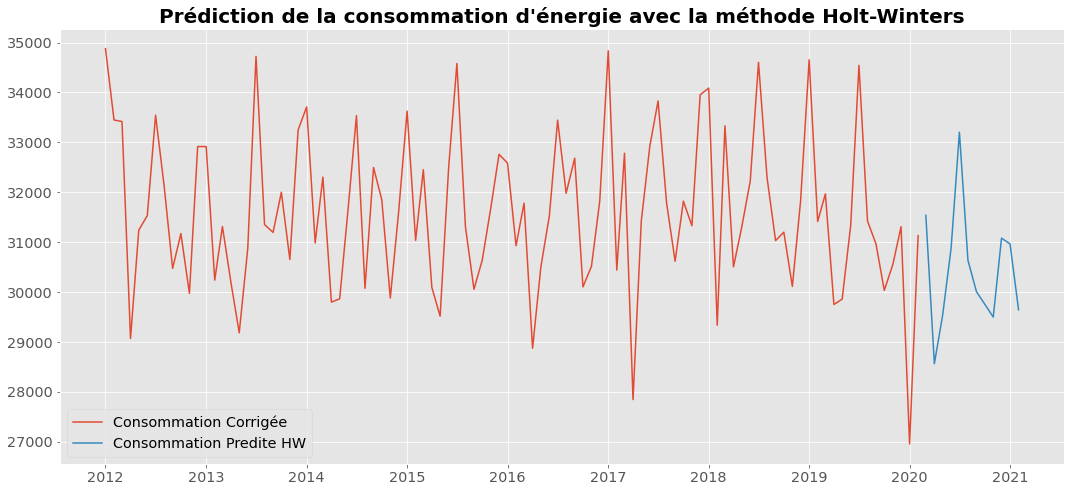

In [37]:
# Calcul de la prédiction selon la méthode Holt-Winters
hw = ExponentialSmoothing(np.asarray(conso_dju['corr_conso']), seasonal_periods = 12, trend = 'add', seasonal = 'add').fit()
hw_pred = hw.forecast(12)

# Création d'un graphique pour afficher la prédiction
plt.figure(figsize = (18,8))
plt.plot(conso_dju['corr_conso'], label = 'Consommation Corrigée')
plt.plot(pd.date_range(conso_dju.index[len(conso_dju)-1], periods = 12, freq = 'M'), hw_pred, label = 'Consommation Predite HW')

plt.legend()
plt.title("Prédiction de la consommation d'énergie avec la méthode Holt-Winters")
plt.savefig("Graphs/Prédiction de la consommation d'énergie avec la méthode Holt-Winters")
plt.show()

#### Vérification des résidus de notre modèle

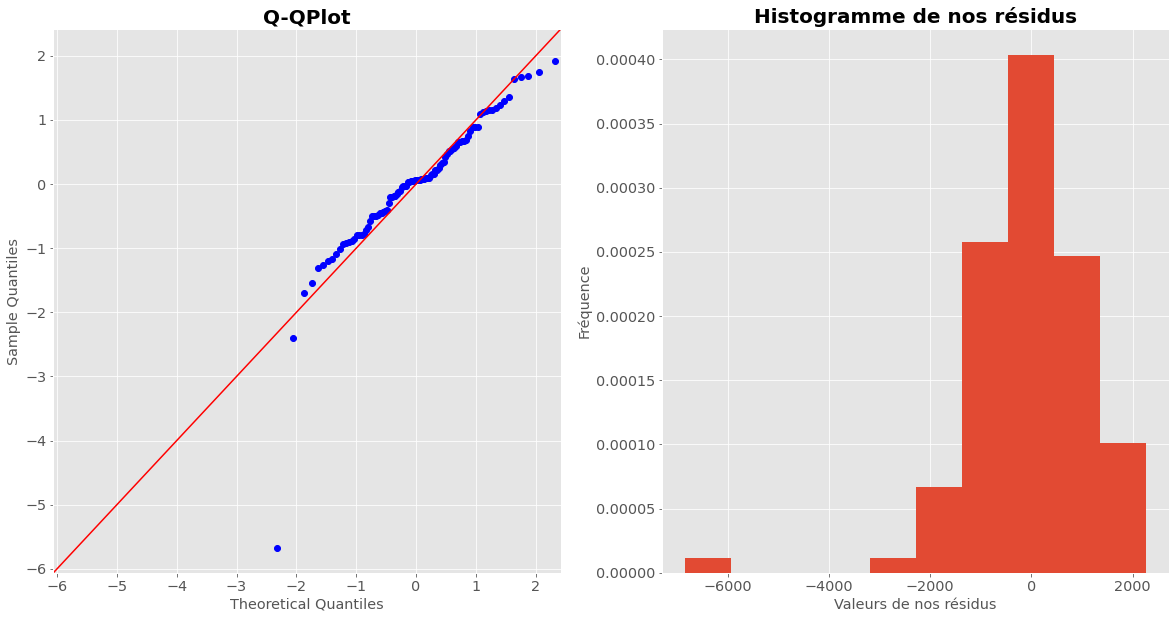

In [38]:
# Création de deux graphique qui vont nous renseigner sur la distribution de nos résidus et si ils suivent une loi normale
# grâce à un graphique de type QQplot
fig, ax = plt.subplots(1, 2, figsize = (20, 10))


# Stockage des résidus dans une variable
res = hw.resid # residuals

plt.hist(res, density = True)

# Réalisation de notre Diagrammes de probabilité à partir de nos résidus
pplot = sm.ProbPlot(res, fit = True)
fig = pplot.qqplot(line = "45", ax = ax[0])

ax[0].set_title('Q-QPlot')
ax[1].set_title('Histogramme de nos résidus')
ax[1].set_xlabel('Valeurs de nos résidus')
ax[1].set_ylabel('Fréquence')

plt.savefig('Graphs/qqplot_histo_residus_reg.png')
plt.show()

In [39]:
# Importation de la librairie 'metrics' de sklearn les différentes métrics de notre modèle
from sklearn.metrics import *

# Calcul de la moyenne des erreurs absolue
MAE = mean_absolute_error(y_reel12, hw_pred)
# Calcul de la moyenne des écart au carré
MSE = mean_squared_error(y_reel12, hw_pred)
# Calcul de la racine de la moyenne des écart au carré
RMSE = np.sqrt(MSE)
# Calcul de la MAPE (Mean Absolut Percentage)
MAPE = np.mean(np.abs((y_reel12 - hw_pred) / y_reel12)) * 100

print('MAE = ', round(MAE, 2), ', MSE = ', round(MSE, 2), ', RMSE = ', round(RMSE, 2), ', MAPE = ', round(MAPE, 2))

MAE =  1044.61 , MSE =  2065141.76 , RMSE =  1437.06 , MAPE =  3.51


### La méthode SARIMA (Seasonnal AutoRegressive Integrated Moving Average)

### La synthèse
#### La démarche adoptée est la suivante :

- stationnarisation (éventuellement),

- identification a priori de modèles potentiels,

- estimation des modèles potentiels,

- vérification des modèles potentiels,

- choix définitif d'un modèle,

- prévision à l'aide du modèle choisi,

- analyse a posteriori de la prévision.

### stationnarisation

Pour pouvoir éffectuer une méthode SARIMA nous devons tout d'abord nous assuré que notre série temporelle est bien stationnarisé et pour cela nous allons utiliser la différenciation.

La stationnarité signifie que les statistiques de la série temporelle ne dépendent pas du temps.

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# acf => calcule de l'autocorrélation
# pacf => estimation de l'autocorrélation partiel

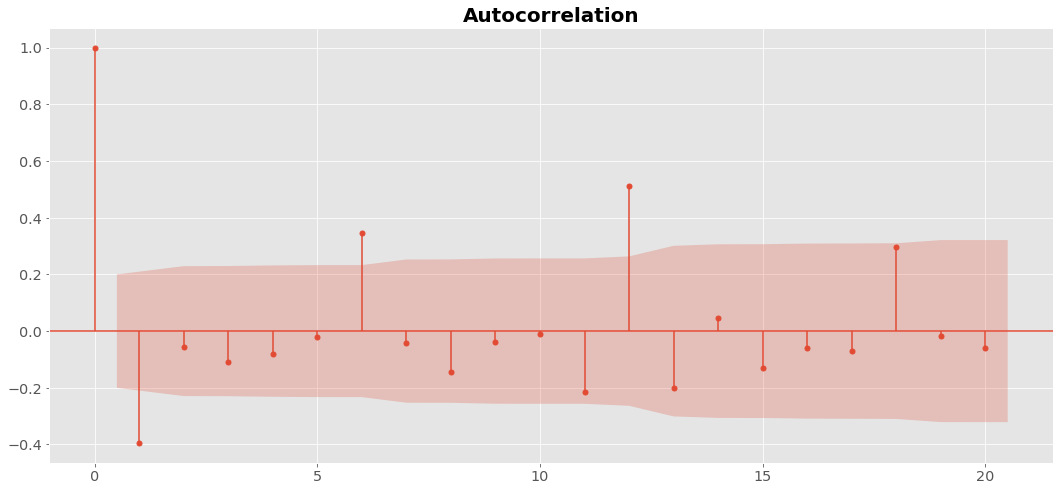

In [41]:
# Utilisation d'un autocorrélogramme pour savoir qu'elles est la valeur qui provoque la non-stationnarisation de ma série temporelle
y = conso_corr
y_dif1 = y.diff().dropna()

# Différentielle de 1, y - (y-1)
plot_acf(np.asarray(y_dif1[1:]))

plt.savefig('Graphs/autocorrélogramme_brute.png')
plt.show()

On constate que les valeurs 6, 12 et 18 nous empêche de dire que ma série est stationnaire(Convergence lente vers le point 0).

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 6. On effectue cette fois la différenciation $(I−B^{12})$ .

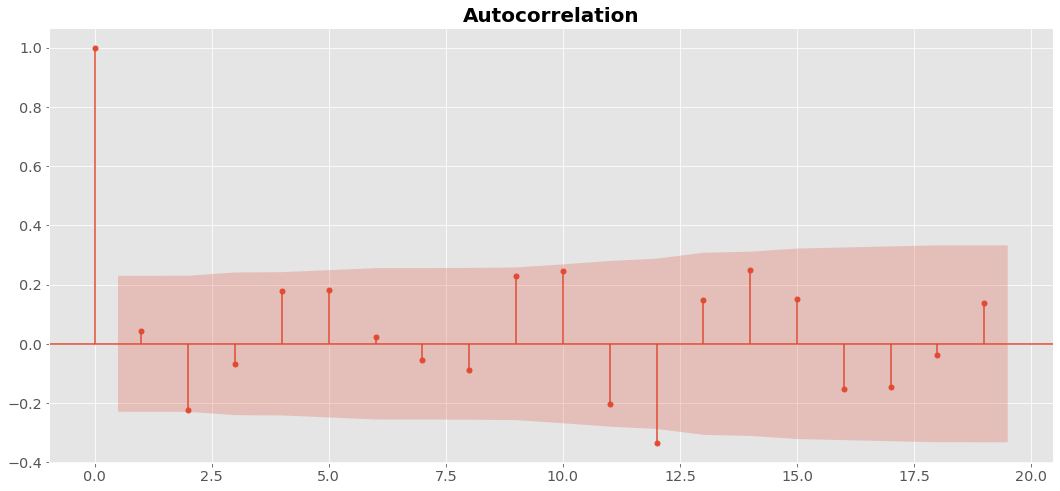

In [42]:
# Différenciation de notre série à 12
y_dif_12 =  y.diff(periods = 12).dropna()

plot_acf(np.asarray(y_dif_12[13:]))

plt.savefig('Graphs/autocorrélogramme_différenciel(12).png')
plt.show()

Notre corrélogramme nous montre que notre série est bien stationnaire avec une différenciation de période 12.

In [43]:
# Vérifions qu'avec un différentiel de 12 notre série temporelle est bien stationnaire avec un test de Dickey-Fuller
_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(y_dif_12)
print(round(p_value, 2))

0.5


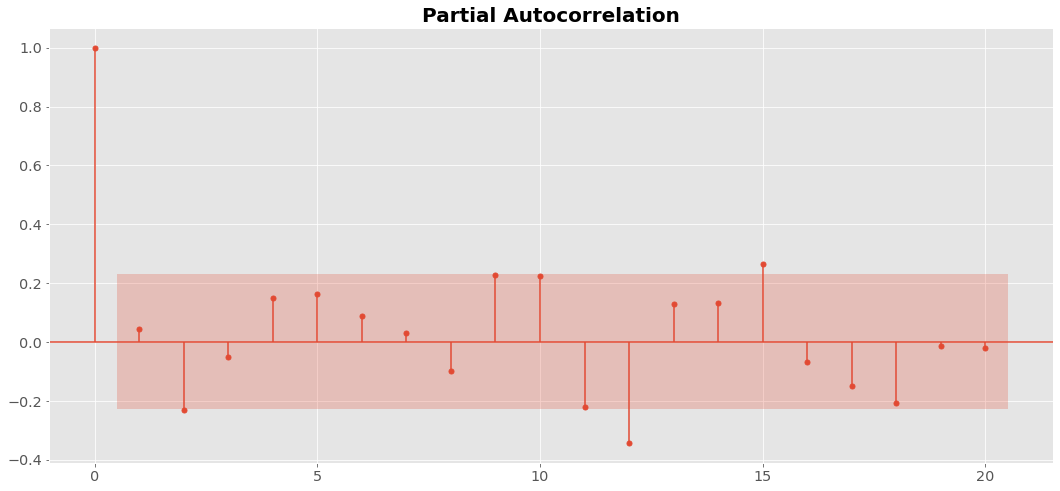

In [44]:
# Réalisation de l'autocorrélogramme partiel, qui va nous montrer la corrélation entre nos observations
# de notre série chronologique séparées par k unités de temps, après prise en compte de tous les autres termes ayant un décalage plus court
plot_pacf(np.asarray(y_dif_12[13:]), lags = 20)

plt.savefig('Graphs/autocorrélogramme_partiel.png')
plt.show()

### identification a priori de modèles potentiels
Détermination du meilleur modèle de prévision 

In [45]:
# Ce module implémente de nombreuses briques d'itérateurs inspirées par des éléments de APL, Haskell et SML. Toutes ont été retravaillées dans un format adapté à Python.
import itertools

# Listing de toutes les combinaisons possible des ordes p, d et q
# itertools.product => produit cartésien, équivalent à une boucle for imbriquée
pdq_list = list(itertools.product(range(3), range(2), range(3)))

In [46]:
# Listing de toutes les combinaisons possible des ordes P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]

In [47]:
# Nombre de configurations total pour un modèle SARIMA
n = len(pdq_list) * len(PDQ_list)

In [48]:
# Dataframe pour stockage des valeurs
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[], 'ljungbox':[], 'pvalues':[]})
counter = 1

In [49]:
# Itération sur toutes les combinaisons
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            #Instanciation et entrainement du modèle SARIMA
            mod = SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity = False, enforce_invertibility = False)
            result = mod.fit()
                    
            #Intégration des indicateurs dans le précédent dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            'ljungbox': acorr_ljungbox(result.resid, lags=12)[1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
        except:
            continue

In [50]:
# Sélection des modèles SARIMA les plus optimaux selon les tests de significativité des paramètres 
# et de blancheur du résidu sont validés au niveau 5%
results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA_filter[results_SARIMA_filter['pvalues'] < 0.05]
results_SARIMA_filter

,modele,aic,bic,ljungbox,pvalues
20,"(0, 0, 1)x(0, 0, 2, 12)",2399.517757,2408.624422,0.562815,0.000000e+00
26,"(0, 0, 1)x(1, 0, 2, 12)",1602.461524,1613.844854,0.078798,0.000000e+00
38,"(0, 0, 2)x(0, 0, 2, 12)",2365.931533,2377.244933,0.727571,0.000000e+00
54,"(0, 1, 0)x(0, 0, 0, 12)",1749.987484,1752.551833,0.560448,8.200082e-09
55,"(0, 1, 0)x(0, 0, 1, 12)",1514.579334,1519.440968,0.666107,1.901268e-09
...,...,...,...,...,...
318,"(2, 1, 2)x(2, 0, 0, 12)",1222.538920,1238.377679,0.432110,2.336666e-17
319,"(2, 1, 2)x(2, 0, 1, 12)",1222.671025,1240.772464,0.647802,2.010952e-13
320,"(2, 1, 2)x(2, 0, 2, 12)",1208.108676,1228.345133,0.615803,2.217035e-14
321,"(2, 1, 2)x(2, 1, 0, 12)",1029.277983,1043.820745,0.086627,1.821063e-03


In [51]:
# Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
# AIC => Score pénalisant les modèles ayant beaucoup de paramètres (le but ayant un score AIC le plus faible)
# BIC => Score pénalisant les modèles ayant beaucoup de paramètres tout en tenant compte du nombre d'échantillon (le but ayant un score BIC le plus faible)
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending = True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending = True)
results_SARIMA_filter.sort_values('rank_aic', ascending = True)[:10]

,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic
185,"(1, 1, 1)x(0, 1, 2, 12)",10.000000,20.387687,0.853730,0.000000e+00,1.0,1.0
203,"(1, 1, 2)x(0, 1, 2, 12)",12.000000,24.362658,0.593416,0.000000e+00,2.0,2.0
95,"(0, 1, 2)x(0, 1, 2, 12)",368.117858,378.420073,0.089917,0.000000e+00,3.0,3.0
304,"(2, 1, 1)x(2, 1, 1, 12)",1025.556633,1040.099395,0.504042,5.669967e-14,4.0,5.0
322,"(2, 1, 2)x(2, 1, 1, 12)",1027.023503,1043.643802,0.882524,4.160615e-07,5.0,8.0
303,"(2, 1, 1)x(2, 1, 0, 12)",1027.163918,1039.629143,0.356052,6.626357e-18,6.0,4.0
286,"(2, 1, 0)x(2, 1, 1, 12)",1029.229476,1041.694701,0.087278,4.499663e-11,7.0,7.0
321,"(2, 1, 2)x(2, 1, 0, 12)",1029.277983,1043.820745,0.086627,1.821063e-03,8.0,9.0
285,"(2, 1, 0)x(2, 1, 0, 12)",1030.745679,1041.133366,0.052803,6.051062e-14,9.0,6.0
214,"(1, 1, 2)x(2, 1, 1, 12)",1040.298413,1054.958825,0.345163,0.000000e+00,10.0,10.0


#### Bonus : l'auto_arima

In [52]:
# Utilisation de la fonction 'auto_arima' pour tester plusieurs combinaisons AR & MA pour récupérer le plus performant
model = pm.auto_arima(y.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1524.630, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1532.219, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1528.385, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1525.474, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1528.307, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1523.405, Time=0.42 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1525.878, Time=0.33 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1523.341, Time=0.68 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1524.139, Time=0.53 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1525.223, Time=0.16 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1526.915, Time=0.54 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=1524.179, Time=1.25 sec
 ARIMA(0,1,0)(0,1,2)[12]     

### Verification du meilleur modèle

In [53]:
# Instanciation et entrainement du modèle SARIMA via statsmodels
model = SARIMAX(np.asarray(y), order=(0,1,2), seasonal_order=(0,1,2,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   98
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -756.117
Date:                            Wed, 18 May 2022   AIC                           1522.233
Time:                                    11:29:01   BIC                           1534.446
Sample:                                         0   HQIC                          1527.146
                                             - 98                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1576      0.032     -4.956      0.000      -0.220      -0.095
ma.L2         -0.1354      0.057   

Le test de Ljung-Box est un test de blancheur des résidus. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0 : blancheur des résidus. Dans notre cas le test est supérieur à 0.05 et donc nous ne rejettons pas l'hypothèse H0 (Les données sont distribuées indépendamment).

Le test de Jarque-Bera est un test de normalité. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0 : les résidus suit une distribution normale. D'après la documentation officielle de scipy ce test ne fonctionne que pour un nombre suffisant d'échantillons de données (>2000).

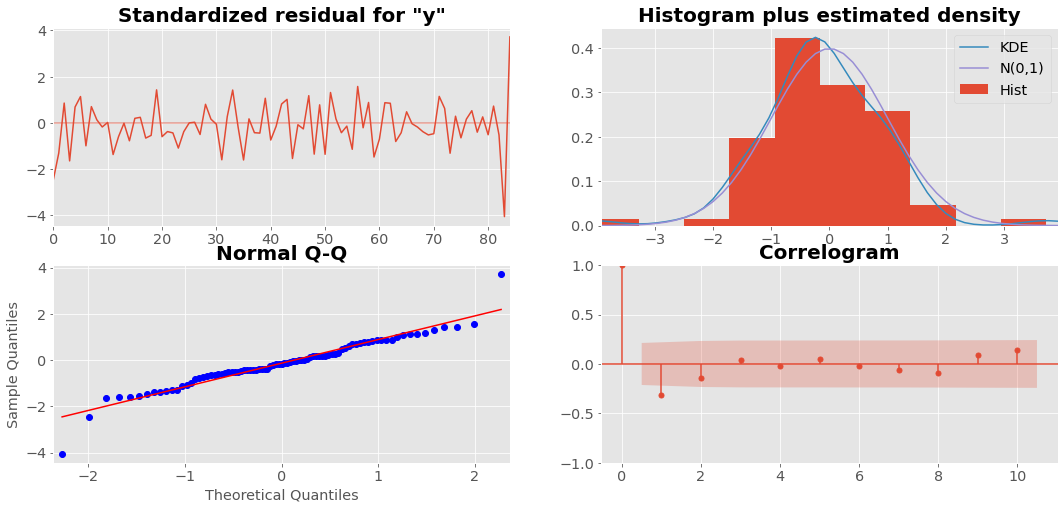

In [54]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
fig = results.plot_diagnostics()
plt.savefig('Graphs/diagnostique rapide.png')

Observations de nos différents diagnostiques :
   - graph_1 -> nous avons des résidus qui semblent fluctuer autour d’une moyenne de zéro et ont une variance uniforme.
   - graph_2 -> le diagramme de densité suggère une distribution normale avec zéro moyen.
   - graph_3 -> Tous les points doivent être parfaitement alignés sur la ligne rouge. Tout écart significatif impliquerait que la distribution est faussée.
   - graph_4 -> Le diagramme ACF Correlogram, montre que les erreurs résiduelles ne sont pas autocorrélées.

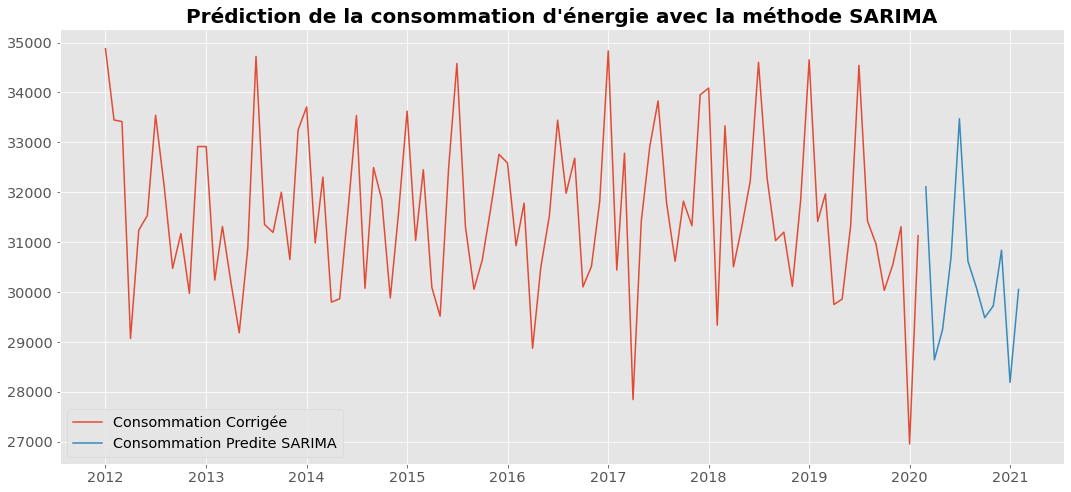

In [55]:
# Calcul de la prédiction selon les processus SARIMA
sar_model = results.get_forecast(12)
sar_pred = sar_model.predicted_mean

# Création d'un graphique pour afficher la prédiction
plt.figure(figsize = (18,8))
plt.plot(conso_dju['corr_conso'], label = 'Consommation Corrigée')
plt.plot(pd.date_range(conso_dju.index[len(conso_dju)-1], periods = 12, freq = 'M'), sar_pred, label = 'Consommation Predite SARIMA')

plt.legend()
plt.title("Prédiction de la consommation d'énergie avec la méthode SARIMA")
plt.savefig("Graphs/Prédiction de la consommation d'énergie avec la méthode SARIMA.png")
plt.show()

In [56]:
# Calcul de la moyenne des erreurs absolue
MAE = mean_absolute_error(y[-12:], sar_pred)
# Calcul de la moyenne des écart au carré
MSE = mean_squared_error(y[-12:], sar_pred)
# Calcul de la racine de la moyenne des écart au carré
RMSE = np.sqrt(MSE)
# Calcul de la MAPE (Mean Absolut Percentage)
MAPE = np.mean(np.abs((y[-12:] - sar_pred) / y[-12:])) * 100

print('MAE = ', round(MAE, 2), ', MSE = ', round(MSE, 2), ', RMSE = ', round(RMSE, 2), ', MAPE = ', round(MAPE, 2))

MAE =  783.12 , MSE =  706117.75 , RMSE =  840.31 , MAPE =  2.57


#### Comparaison méthode Holt-Winters & SARIMA

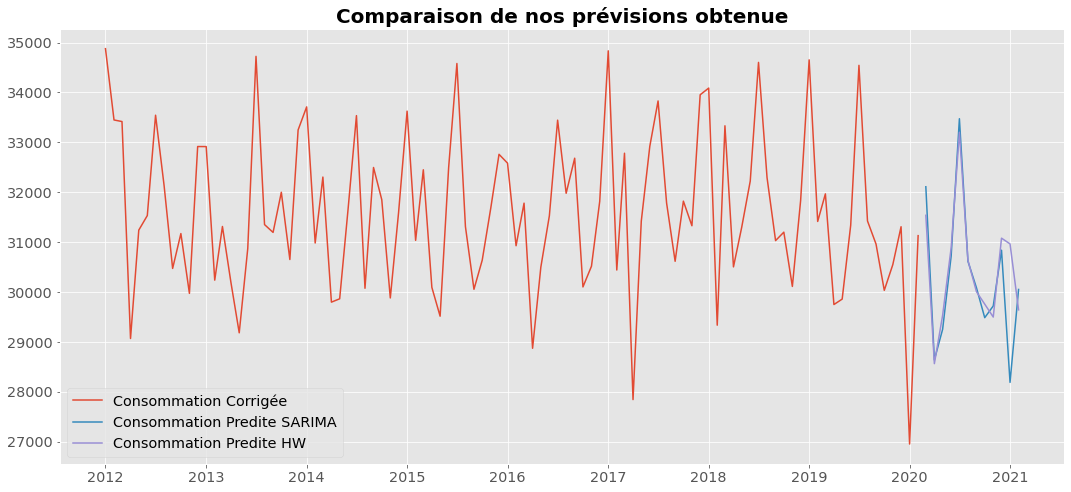

In [57]:
# Création d'un graphique pour afficher la comparaison
plt.figure(figsize = (18,8))
plt.plot(conso_dju['corr_conso'], label = 'Consommation Corrigée')
plt.plot(pd.date_range(conso_dju.index[len(conso_dju)-1], periods = 12, freq = 'M'), sar_pred, label = 'Consommation Predite SARIMA')
plt.plot(pd.date_range(conso_dju.index[len(conso_dju)-1], periods = 12, freq = 'M'), hw_pred, label = 'Consommation Predite HW')

plt.legend()
plt.title("Comparaison de nos prévisions obtenue")
plt.savefig("Graphs/Comparaison de nos prévisions obtenue.png")
plt.show()

### Récapitulatif

Nous avons récupérer la consommation totale de la France en GWh pour les années entre 2012 et Juin 2020, pour pouvoir réaliser une prédiction de consommation pour l'année 2021 car nos données s'arrète en plein milieu de l'année 2020. Pour cela nous avons du corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire(voir Chap.1). Ensuite nous avons dû effectuer une désaisonnalité de notre consommation corrigé grâce aux moyennes mobile pour pouvoir lisser notre série temporelle(voir Chap.2). Ce qui nous faciliteras notre prévisions ce que nous avons effectué durant le chap.3 avec les méthodes Holt-Winters et SARIMA, que nous avons comparer sur notre dernier graphique.